    This tutorial is to get familiar with the GRAND's Coordinate system written in Python. GRAND's coordinate system is developed for the GRAND collaboration and it does not depend on astropy. This tutorial shows a step-by-step process to use them.

    Four coordinate systems (CS) are defined, i.e. ECEF, Geodetic, LTP and GRANDCS. GRANDCS is a subclass of LTP. More coordinate systems, including celestial coordinate systems, and their transformation will be added in future. Defining a coordinate in a required CS is done by instantiating the CS. For example, to define an ECEF or Geodetic CS at the point where equator intersects prime-meridian is done simply by:
    
        ecef     = ECEF(x=6378137, y=0, z=0)
        geodetic = Geodetic(latitude=0, longitude=0, height=0)
        
    Similarly, to define an origin of GRANDCS is done by:
    
        grandcs  = GRANDCS(x=0, y=0, z=0)
    
    These CS can be transformed among themselves by two easy-to-use methods:
    
        1. Instantiating a required CS with a given CS as an input
            
            ecef1     = ECEF(geodetic)    --> changing from Geodetic CS to ECEF CS.
            ecef2     = ECEF(grandcs)     --> changing from GRAND CS to ECEF CS.
            
            geodetic1 = Geodetic(ecef)    --> changing from ECEF CS to Geodetic CS.
            geodetic2 = Geodetic(grandcs) --> changing from GRAND CS to Geodetic CS.
            
            grandcs1  = GRANDCS(ecef)     --> changing from ECEF CS to GRANDCS.
            grandcs1  = GRANDCS(geodetic) --> changing from Geodetic CS to GRANDCS.
            
        2. Calling a method from the given CS object.
            
            ecef1     = geodetic.geodetic_to_ecef()
            ecef2     = grandcs.grand_to_ecef()
            
            geodetic1 = ecef.ecef_to_geodetic()
            geodetic2 = grandcs.grand_to_geodetic()
            
            grandcs1  = ecef.ecef_to_grand()
            grandcs2  = geodetic.geodetic_to_grand()


    GRAND coordinate system requires you to define a local tangential plane (LTP) with given orientation (ENU, NWU etc). GRAND's x-axis points toward the local magnetic North. Y-axis is 90 degree West from the magnetic North. To know the local magnetic North, we must know the declination angle at a given location and observation time (obstime). 'geomagnetic' module is written to calculate local magnetic field and declination angle at a given time and location using some geomagnetic model.

    Using 'geomagnetic' module, magnetic field can be defined in two different ways (see below) depending on the input location. Default geomagnetic model ('IGRF13) and default obstime ('2020-01-01') is used if not given.
        
        1. Location can be given as ECEF, Geodetic, or GRAND coordinate system. 'x' below can be in ECEF, Geodetic, or GRAND CS.
        
            gm = Geomagnet(location=x)    
            gm = Geomagnet(location=x, model='IGRF13', obstime='2021-08-30')
            
        2. Location can be given as latitude, longitude, and height.
        
            gm = Geomagnet(latitude=0, longitude=0, height=0)
            gm = Geomagnet(latitude=0, longitude=0, height=0, model='IGRF13', obstime='2020-08-30')
            
    TypeError will occur if location is not provided. 'obstime' is in isoformat ('2020-08-30') or in datetime.date(2020, 8, 30). If obstime is not provided, a default date ('2020-01-01') is used. After the geomagnetic field is instantiated, you can get the required quantity by:
    
        field       = gm.field          Output: CartesianRepresentation(x=Bx, y=By, z=Bz)
        declination = gm.declination    Output: in degree
        inclination = gm.inclination    Output: in degree
        model       = gm.model          Output: in string
        obstime     = gm.obstime        Output: in datetime.date()
        location    = gm.location       Output: in Geodetic(latitude=x, longitude=x, height=x)
    

In [1]:
# from grand.tools import Coordinates, CartesianRepresentation, SphericalRepresentation, GeodeticRepresentation
# from grand.tools import ECEF, Geodetic, GRAND, LTP
# from grand.tools import Geomagnet

from grand import (
    Coordinates,
    CartesianRepresentation,
    SphericalRepresentation,
    GeodeticRepresentation,
)
from grand import ECEF, Geodetic, GRANDCS, LTP
from grand import Geomagnet

import numpy as np
import datetime

import matplotlib.pyplot as plt

params = {
    "legend.fontsize": 16,
    "axes.labelsize": 22,
    "axes.titlesize": 17,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "figure.figsize": (12, 12),
    "axes.grid": True,
}
plt.rcParams.update(params)

Welcome to JupyROOT 6.26/02


    Basic data structure for all coordinate system is a numpy.ndarray. Coordinate data are stored as 3xn ndarray with random entries, where n=number of coordinate points and n>=1 for point and vector/array.
        
        [[x1], 
         [y1], 
         [z1]]
         
         OR
         
        [[x1, x2, ..xn], 
         [y1, y2, ..yn], 
         [z1, z2, ..zn]]

In [2]:
# Basic data structure.

cord1 = Coordinates(1)  # 3x1ndarray with random entries is formed in this example.
cord2 = Coordinates(5)  # 3x5 ndarray with random entries is formed in this example.

print("---------Basic Data Structure (Random Entries)---------")
print(cord1, type(cord1), "n=1\n")
print(cord2, type(cord2), "n=5\n")
print("Note that random values are automatically selected to fill the array.")

---------Basic Data Structure (Random Entries)---------
[[0. ]
 [0.5]
 [1. ]] <class 'grand.geo.coordinates.Coordinates'> n=1

[[6.8367879e-316 0.0000000e+000 0.0000000e+000 0.0000000e+000
  0.0000000e+000]
 [0.0000000e+000 0.0000000e+000 0.0000000e+000 0.0000000e+000
  0.0000000e+000]
 [0.0000000e+000 0.0000000e+000 0.0000000e+000 0.0000000e+000
  0.0000000e+000]] <class 'grand.geo.coordinates.Coordinates'> n=5

Note that random values are automatically selected to fill the array.


    Cartesian coordinate system is defined as 'CartesianRepresentation' and has x, y, and z as an input. Other Representation (SphericalRepresentation, ECEF, LTP, GRANDCS) can also be given as an input and will automatically be converted into CartesianRepresentation. ECEF, LTP and GRANDCS are based on CartesianRepresentation. Similarly, spherical coordinate system is defined by 'SphericalRepresentation' and has similar features like CartesianRepresentation. theta, phi, and r are inputs of SphericalRepresentation.
        
        cartesian = CartesianRepresentation(x=0, y=0, z=0)
        spherical = SphericalRepresentation(theta=0, phi=0, r=0)
        
    These representations can be transformed among themselves by two easy-to-use methods:
    
        1. Instantiating a required representation with a given representation as an input
            
            cartesian1 = CartesianRepresentation(spherical)  --> changing from spherical to cartesian.
            spherical1 = SphericalRepresentation(cartesian)  --> changing from cartesian to spherical.
            
        2. Calling a method from the given representation object.
            
            cartesian1 = spherical.spherical_to_cartesian()
            spherical1 = cartesian.cartesian_to_spherical()
            
            
    These representations also have getter and setter method.
        
    ----Getter
        x = cartesian.x
        y = cartesian.y
        z = cartesian.z
        
    ----Setter
        cartesian.x = x*x
        cartesian.y = y*y
        cartesian.z = z*z
        
    Similar methods for SphericalRepresentation but use theta, phi, and r instead of x, y, and z.

In [3]:
print("---------Cartesian Representation--------")
x = np.ones(5)  # [1. 1. 1. 1. 1.]
y = 1 + x  # [2. 2. 2. 2. 2.]
z = 1 + y  # [3. 3. 3. 3. 3.]

# forms 3xn ndarray ([[x1, x2, ..xn], [y1, y2, ..yn], [z1, z2, ..zn]], n=len(x))
cart1 = CartesianRepresentation(x=1, y=2, z=3)
cart2 = CartesianRepresentation(x=x, y=y, z=z)

print("\n-- 3x1 array. n=1")
print(cart1, type(cart1), "Initial")

print("--getter")
print(cart1.x, "X", type(cart1), "getter")
print(cart1.y, "Y", type(cart1), "getter")
print(cart1.z, "Z", type(cart1), "getter")

cart1.x = cart1.x ** 2
cart1.y = cart1.y ** 2
cart1.z = cart1.z ** 2
print("--setter")
print(cart1, type(cart1), "setter (squared)")

cts1a = cart1.cartesian_to_spherical()
cts1b = SphericalRepresentation(cart1)
print("--Cartesian to Spherical (theta, phi, r)")
print(cts1a, type(cts1a), "style 1")
print(cts1b, type(cts1b), "style 2")

print("\n-- 3x5 array. n=5")
print(cart2, type(cart2), "Initial")

print("--getter")
print(cart2.x, "X", type(cart2), "getter")
print(cart2.y, "Y", type(cart2), "getter")
print(cart2.z, "Z", type(cart2), "getter")

cart2.x = x * x
cart2.y = y * y
cart2.z = z * z
print("--setter")
print(cart2, type(cart2), "setter (squared)")
cts2a = cart2.cartesian_to_spherical()
cts2b = SphericalRepresentation(cart2)
print("--Cartesian to Spherical (theta, phi, r)")
print(cts2a, type(cts2a), "style 1")
print(cts2b, type(cts2b), "style 2")

---------Cartesian Representation--------

-- 3x1 array. n=1
[[1.]
 [2.]
 [3.]] <class 'grand.geo.coordinates.CartesianRepresentation'> Initial
--getter
[1.] X <class 'grand.geo.coordinates.CartesianRepresentation'> getter
[2.] Y <class 'grand.geo.coordinates.CartesianRepresentation'> getter
[3.] Z <class 'grand.geo.coordinates.CartesianRepresentation'> getter
--setter
[[1.]
 [4.]
 [9.]] <class 'grand.geo.coordinates.CartesianRepresentation'> setter (squared)
--Cartesian to Spherical (theta, phi, r)
[[24.61359765]
 [75.96375653]
 [ 9.89949494]] <class 'grand.geo.coordinates.SphericalRepresentation'> style 1
[[24.61359765]
 [75.96375653]
 [ 9.89949494]] <class 'grand.geo.coordinates.SphericalRepresentation'> style 2

-- 3x5 array. n=5
[[1. 1. 1. 1. 1.]
 [2. 2. 2. 2. 2.]
 [3. 3. 3. 3. 3.]] <class 'grand.geo.coordinates.CartesianRepresentation'> Initial
--getter
[1. 1. 1. 1. 1.] X <class 'grand.geo.coordinates.CartesianRepresentation'> getter
[2. 2. 2. 2. 2.] Y <class 'grand.geo.coordinat

In [4]:
print("---------Spherical Representation--------")

t = np.ones(5)  # theta=1 degree
p = 1 + t  # phi=2 degree
r = 1 + p  # r=3 m

sphr1 = SphericalRepresentation(theta=1, phi=2, r=3)
sphr2 = SphericalRepresentation(theta=t, phi=p, r=r)

print("\n-- 3x1 array. n=1")
print(sphr1, type(sphr1), "Initial")

print("--getter")
print(sphr1.theta, "theta", type(sphr1.theta), "getter")
print(sphr1.phi, "phi", type(sphr1.phi), "getter")
print(sphr1.r, "r", type(sphr1.r), "getter")

sphr1.theta = sphr1.theta ** 2
sphr1.phi = sphr1.phi ** 2
sphr1.r = sphr1.r ** 2
print("--setter")
print(sphr1, type(sphr1), "setter (squared)")

print("--Spherical to Cartesian (x, y, z)")
stc1a = sphr1.spherical_to_cartesian()
stc1b = CartesianRepresentation(sphr1)
print(stc1a, type(stc1a), "style 1")
print(stc1b, type(stc1b), "style 2")

print("\n-- 3x5 array. n=5")
print(sphr2, type(sphr2), "Initial")

print("--getter")
print(sphr2.theta, "theta", type(sphr2.theta), "getter")
print(sphr2.phi, "phi", type(sphr2.phi), "getter")
print(sphr2.r, "r", type(sphr2.r), "getter")

sphr2.theta = sphr2.theta ** 2
sphr2.phi = sphr2.phi ** 2
sphr2.r = sphr2.r ** 2
print("--setter")
print(sphr2, type(sphr2), "setter (squared)")

print("--Spherical to Cartesian (x, y, z)")
stc2a = sphr2.spherical_to_cartesian()
stc2b = CartesianRepresentation(sphr2)
print(stc2a, type(stc2a), "style 1")
print(stc2b, type(stc2b), "style 2")

---------Spherical Representation--------

-- 3x1 array. n=1
[[1.]
 [2.]
 [3.]] <class 'grand.geo.coordinates.SphericalRepresentation'> Initial
--getter
[1.] theta <class 'grand.geo.coordinates.SphericalRepresentation'> getter
[2.] phi <class 'grand.geo.coordinates.SphericalRepresentation'> getter
[3.] r <class 'grand.geo.coordinates.SphericalRepresentation'> getter
--setter
[[1.]
 [4.]
 [9.]] <class 'grand.geo.coordinates.SphericalRepresentation'> setter (squared)
--Spherical to Cartesian (x, y, z)
[[0.15668904]
 [0.01095676]
 [8.99862926]] <class 'grand.geo.coordinates.CartesianRepresentation'> style 1
[[0.15668904]
 [0.01095676]
 [8.99862926]] <class 'grand.geo.coordinates.CartesianRepresentation'> style 2

-- 3x5 array. n=5
[[1. 1. 1. 1. 1.]
 [2. 2. 2. 2. 2.]
 [3. 3. 3. 3. 3.]] <class 'grand.geo.coordinates.SphericalRepresentation'> Initial
--getter
[1. 1. 1. 1. 1.] theta <class 'grand.geo.coordinates.SphericalRepresentation'> getter
[2. 2. 2. 2. 2.] phi <class 'grand.geo.coordinat

    Geodetic representation is defined as 'GeodeticRepresentation' and has latitude, longitude, and height as inputs. Geodetic coordinate system is based on GeodeticRepresentation.

        geodetic = GeodeticRepresentation(latitude=0, longitude=0, height=0)
    
    This representation have getter and setter method.

    ----Getter
        lat = geodetic.latitude
        lon = geodetic.longitude
        het = geodetic.height

    ----Setter
        geodetic.latitude  = lat*lat
        geodetic.longitude = lon*lon
        geodetic.height    = het*het
        
    Note that there is no conversion from GeodeticRepresentation to CartesianRepresentaiton and SphericalRepresentation because geodetic has a fixed axes whereas cartesian and spherical do not.

In [5]:
print("---------Geodetic Representation--------")
lat = np.zeros(4)
lon = np.zeros(4)
height = 2 * np.ones(4)  # 2 m above mean sea level at lat=0, lon=0.
geod1 = GeodeticRepresentation(latitude=0, longitude=0, height=2)
geod2 = GeodeticRepresentation(latitude=lat, longitude=lon, height=height)

print("\n-- 3x1 array. n=1")
print(geod1, type(geod1), "Initial")

print("--getter")
print(geod1.latitude, "latitude [deg] ", type(geod1.latitude), "getter")
print(geod1.longitude, "longitude [deg]", type(geod1.longitude), "getter")
print(geod1.height, "height [m]     ", type(geod1.height), "getter")

geod1.latitude = geod1.latitude ** 2
geod1.longitude = geod1.longitude ** 2
geod1.height = geod1.height ** 2
print("--setter")
print(geod1, type(geod1), "setter (squared)")

print("\n--3x4 array. n=4")
print(geod2, type(geod2), "Initial")

print("--getter")
print(geod2.latitude, "latitude [deg] ", type(geod2.latitude), "getter")
print(geod2.longitude, "longitude [deg]", type(geod2.longitude), "getter")
print(geod2.height, "height [m]     ", type(geod2.height), "getter")

geod2.latitude = geod2.latitude ** 2
geod2.longitude = geod2.longitude ** 2
geod2.height = geod2.height ** 2
print("--setter")
print(geod2, type(geod2), "setter (squared)")

---------Geodetic Representation--------

-- 3x1 array. n=1
[[0.]
 [0.]
 [2.]] <class 'grand.geo.coordinates.GeodeticRepresentation'> Initial
--getter
[0.] latitude [deg]  <class 'grand.geo.coordinates.GeodeticRepresentation'> getter
[0.] longitude [deg] <class 'grand.geo.coordinates.GeodeticRepresentation'> getter
[2.] height [m]      <class 'grand.geo.coordinates.GeodeticRepresentation'> getter
--setter
[[0.]
 [0.]
 [4.]] <class 'grand.geo.coordinates.GeodeticRepresentation'> setter (squared)

--3x4 array. n=4
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [2. 2. 2. 2.]] <class 'grand.geo.coordinates.GeodeticRepresentation'> Initial
--getter
[0. 0. 0. 0.] latitude [deg]  <class 'grand.geo.coordinates.GeodeticRepresentation'> getter
[0. 0. 0. 0.] longitude [deg] <class 'grand.geo.coordinates.GeodeticRepresentation'> getter
[2. 2. 2. 2.] height [m]      <class 'grand.geo.coordinates.GeodeticRepresentation'> getter
--setter
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [4. 4. 4. 4.]] <class 'grand.geo.coordinates.Geo

    ----------- Geodetic Coordinate System ----------------
    
    Generic container for Geodetic coordinate system. Center of this frame is the center of Earth.

	Latitude: Angle north and south of the equator. +ve in the northern hemisphere, 
			  -ve in the southern hemisphere. Range: -90 deg (South Pole) 
			  to +90 deg (North Pole). In equator, latitude = 0.
	Longitude: Angle east and west of the Prime Meridian. The Prime Meridian 
			   is a north-south line that passes through Greenwich, UK. 
			   +ve to the east of the Prime Meridian, -ve to the west. 
			   Range: -180 deg to +180 deg.
	Height:	Also called altitude or elevation, this represents the height above 
			the Earth ellipsoid, measured in meters. The Earth ellipsoid is a 
			mathematical surface defined by a semi-major axis and a semi-minor axis. 
			The most common values for these two parameters are defined by 
			the World Geodetic Standard 1984 (WGS-84). The WGS-84 ellipsoid is 
			intended to correspond to mean sea level. A Geodetic height of zero 
			therefore roughly corresponds to sea level, with positive values increasing 
			away from the Earth’s center. The theoretical range of height values is 
			from the center of the Earth (about -6,371km) to positive infinity. 

    This CS is built on top of GeodeticRepresentation and has latitude, longitude, and height as inputs. Latitude, longitude, and height can be either number or numpy.ndarray. It also takes other known coordinate system as an input and automatically convert it into Geodetic CS. It has getter and setter method.

    geodetic = Geodetic(latitude=0, longitude=0, height=0)
    geodetic = Geodetic(latitude=array, longitude=array, height=array)
    geodetic = Geodetic(ecef)
    geodetic = Geodetic(grandcs)

    ----Getter
        lat = geodetic.latitude
        lon = geodetic.longitude
        het = geodetic.height

    ----Setter
        geodetic.latitude  = lat*lat
        geodetic.longitude = lon*lon
        geodetic.height    = het*het
        
    There are two methods to transform from other known coordinate system to Geodetic CS.
    
    1. Instantiating a required CS with a given CS as an input
    
        geodetic1 = Geodetic(ecef)    --> changing from ECEF CS to Geodetic CS.
        geodetic2 = Geodetic(grandcs) --> changing from GRAND CS to Geodetic CS.

    2. Calling a method from the given CS object.

        geodetic1 = ecef.ecef_to_geodetic()
        geodetic2 = grandcs.grand_to_geodetic()



In [6]:
geodtic1 = Geodetic(latitude=0, longitude=0, height=2)
geodtic2 = Geodetic(latitude=lat, longitude=lon, height=height)

print("----3x1 Geodetic (lat, lon, height array input)")
print(geodtic1, type(geodtic1), "Initial")

print("--getter")
print(geodtic1.latitude, "latitude ", type(geodtic1), "getter")
print(geodtic1.longitude, "longitude", type(geodtic1), "getter")
print(geodtic1.height, "height   ", type(geodtic1), "getter")

geodtic1.latitude = geodtic1.latitude + 10
geodtic1.longitude = geodtic1.longitude + 10
geodtic1.height = geodtic1.height + 10
print("--setter")
print(geodtic1, type(geodtic1), "setter (added 10) \n")

print("----3x4 Geodetic (lat, lon, height array input)-----")
print(geodtic2, type(geodtic1), "Initial")

print("--getter")
print(geodtic2.latitude, "latitude ", type(geodtic2), "getter")
print(geodtic2.longitude, "longitude", type(geodtic2), "getter")
print(geodtic2.height, "height   ", type(geodtic2), "getter")

geodtic2.latitude = geodtic2.latitude + 10
geodtic2.longitude = geodtic2.longitude + 10
geodtic2.height = geodtic2.height + 10
print("--setter")
print(geodtic2, type(geodtic2), "setter (added 10) \n")


Ex = 6378139 * np.ones(5)  # 2 m above mean sea level. R_earth_eqr = 6378137 m.
Ey = np.zeros(5)
Ez = np.zeros(5)
ka = np.zeros(5)

ecef = ECEF(x=Ex, y=Ey, z=Ez)  # more on this later.
grandcs = GRANDCS(x=ka, y=ka, z=ka)  # GRANDCS origin, default obstime. more on this later.
geodtic1 = Geodetic(latitude=0, longitude=0, height=2)
geodtic2 = Geodetic(latitude=lat, longitude=lon, height=height)

print("\n----Geodetic to other cs transformation------\n")
gte1a = ECEF(geodtic1)
gte1b = geodtic1.geodetic_to_ecef()

print("----3x1 array")

print("--to ECEF")
print(geodtic1, type(geodtic1), "Initial")
print(gte1a, type(gte1a), "style 1")
print(gte1b, type(gte1b), "style 2")

print("--to GRANDCS")
gtG1a = GRANDCS(geodtic1)
gtG1b = geodtic1.geodetic_to_grandcs()
print(gtG1a, type(gtG1a), "style 1")
print(gtG1b, type(gtG1b), "style 2")

gte2a = ECEF(geodtic2)
gte2b = geodtic2.geodetic_to_ecef()

print("\n----3x4 array")

print("--to ECEF")
print(geodtic2, type(geodtic2), "Initial")
print(gte2a, type(gte2a), "style 1")
print(gte2b, type(gte2b), "style 2")

print("--to GRANDCS")
gtG2a = GRANDCS(geodtic2)
gtG2b = geodtic2.geodetic_to_grandcs()
print(gtG2a, type(gtG2a), "style 1")
print(gtG2b, type(gtG2b), "style 2")

print("\n----Mathematical Operations (shape should be the same)")
print("geodetic1*geodetic1 + 3*geodetic1")
print(geodtic1 * geodtic1 + 3 * geodtic1)
print("geodtic2*geodtic2 + 3*geodtic2")
print(geodtic2 * geodtic2 + 3 * geodtic2)

----3x1 Geodetic (lat, lon, height array input)
[[0.]
 [0.]
 [2.]] <class 'grand.geo.coordinates.Geodetic'> Initial
--getter
[0.] latitude  <class 'grand.geo.coordinates.Geodetic'> getter
[0.] longitude <class 'grand.geo.coordinates.Geodetic'> getter
[2.] height    <class 'grand.geo.coordinates.Geodetic'> getter
--setter
[[10.]
 [10.]
 [12.]] <class 'grand.geo.coordinates.Geodetic'> setter (added 10) 

----3x4 Geodetic (lat, lon, height array input)-----
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [2. 2. 2. 2.]] <class 'grand.geo.coordinates.Geodetic'> Initial
--getter
[0. 0. 0. 0.] latitude  <class 'grand.geo.coordinates.Geodetic'> getter
[0. 0. 0. 0.] longitude <class 'grand.geo.coordinates.Geodetic'> getter
[2. 2. 2. 2.] height    <class 'grand.geo.coordinates.Geodetic'> getter
--setter
[[10. 10. 10. 10.]
 [10. 10. 10. 10.]
 [12. 12. 12. 12.]] <class 'grand.geo.coordinates.Geodetic'> setter (added 10) 


----Geodetic to other cs transformation------

----3x1 array
--to ECEF
[[0.]
 [0.]
 [2.]] <c

    ----------- ECEF Coordinate System ----------------

    Generic container for Earth-Centered Earth-Fixed (ECEF) coordinate system. Center of Earth is the origin of this frame.

	ECEF is a right-handed Cartesian coordinate system with the origin at the Earth’s center. This coordinate frame is fixed with respect to the Earth (i.e., rotates along with the Earth). Units are in meters. The three axis are defined as follows:
	x:	Passes through the equator at the Prime Meridian (latitude = 0, longitude = 0).
	y:	Passes through the equator 90 degrees east of the Prime Meridian 
		(latitude = 0, longitude = 90 degrees).
	z:	Passes through the North Pole (latitude = 90 degrees, longitude = any value).

    This CS is built on top of CartesianRepresentation and has x, y, and z as an input. x, y, and z can be either number or numpy.ndarray. It also takes other known coordinate system as an input and automatically convert it into ECEF CS. It has getter and setter method.

    ecef = ECEF(x=0, y=0, z=0)
    ecef = ECEF(x=ndarray, y=ndarray, z=ndarray)
    ecef = ECEF(geodetic)
    ecef = ECEF(grandcs)
    
    ----Getter
        x = ecef.x
        y = ecef.y
        z = ecef.z

    ----Setter
        ecef.x = x*x
        ecef.y = y*y
        ecef.z = z*z

    There are two methods to transform from other known coordinate system to ECEF CS.
    
    1. Instantiating a required CS with a given CS as an input
    
        ecef1 = ECEF(geodetic) --> changing from Geodetic CS to ECEF CS.
        ecef2 = ECEF(grandcs)  --> changing from GRAND CS to ECEF CS.

    2. Calling a method from the given CS object.

        ecef1 = geodetic.geodetic_to_ecef()
        ecef2 = grandcs.grand_to_ecef()


In [7]:
Ex = 6378139 * np.ones(4)  # 2 m above mean sea level. R_earth_eqr = 6378137 m.
Ey = np.zeros(4)
Ez = np.zeros(4)
ka = np.zeros(4)

ecef1 = ECEF(x=6378139, y=0, z=0)  # R_earth_eq = 6378137 m
ecef2 = ECEF(x=Ex, y=Ey, z=Ez)  # R_earth_eq = 6378137 m

print("----3x1 ECEF (x, y, z array input)")
print(ecef1, type(ecef1), "Initial")

print("--getter")
print(ecef1.x, "x", type(ecef1.x), "getter")
print(ecef1.y, "y", type(ecef1.y), "getter")
print(ecef1.z, "z", type(ecef1.z), "getter")

ecef1.x = ecef1.x + 10
ecef1.y = ecef1.y + 10
ecef1.z = ecef1.z + 10
print("--setter")
print(ecef1, type(ecef1), "setter (added 10) \n")

print("----3x4 ECEF (x, y, z array input)-----")
print(ecef2, type(ecef1), "Initial")

print("--getter")
print(ecef2.x, "x", type(ecef2.x), "getter")
print(ecef2.y, "y", type(ecef2.y), "getter")
print(ecef2.z, "z", type(ecef2.z), "getter")

ecef2.x = ecef2.x + 10
ecef2.y = ecef2.y + 10
ecef2.z = ecef2.z + 10
print("--setter")
print(ecef2, type(ecef2), "setter (added 10) \n")

ecef1 = ECEF(x=6378139, y=0, z=0)  # R_earth_eq = 6378137 m
ecef2 = ECEF(x=Ex, y=Ey, z=Ez)  # R_earth_eq = 6378137 m

print("\n----ECEF to other cs transformation------\n")
etg1a = Geodetic(ecef1)
etg1b = ecef1.ecef_to_geodetic()

print("----3x1 array")
print(ecef1, type(ecef1), "Initial")

print("--to Geodetic")
print(etg1a, type(etg1a), "style 1")
print(etg1b, type(etg1b), "style 2")

print("--to GRANDCS")
etG1a = GRANDCS(ecef1)
etG1b = ecef1.ecef_to_grandcs()
print(etG1a, type(etG1a), "style 1")
print(etG1b, type(etG1b), "style 2")

etg2a = Geodetic(ecef2)
etg2b = ecef2.ecef_to_geodetic()

print("\n----3x4 array")
print(ecef2, type(ecef2), "Initial")

print("--to Geodetic")
print(etg2a, type(etg2a), "style 1")
print(etg2b, type(etg2b), "style 2")

print("--to GRANDCS")
etG2a = GRANDCS(ecef2)
etG2b = ecef2.ecef_to_grandcs()
print(etG2a, type(etG2a), "style 1")
print(etG2b, type(etG2b), "style 2")

print("\n----Mathematical Operation (shape should be the same)")
print("ecef1*ecef1 + 3*ecef1")
print(ecef1 * ecef1 + 3 * ecef1)
print("ecef2*ecef2 + 3*ecef2")
print(ecef2 * ecef2 + 3 * ecef2)

----3x1 ECEF (x, y, z array input)
[[6378139.]
 [      0.]
 [      0.]] <class 'grand.geo.coordinates.ECEF'> Initial
--getter
[6378139.] x <class 'grand.geo.coordinates.ECEF'> getter
[0.] y <class 'grand.geo.coordinates.ECEF'> getter
[0.] z <class 'grand.geo.coordinates.ECEF'> getter
--setter
[[6.378149e+06]
 [1.000000e+01]
 [1.000000e+01]] <class 'grand.geo.coordinates.ECEF'> setter (added 10) 

----3x4 ECEF (x, y, z array input)-----
[[6378139. 6378139. 6378139. 6378139.]
 [      0.       0.       0.       0.]
 [      0.       0.       0.       0.]] <class 'grand.geo.coordinates.ECEF'> Initial
--getter
[6378139. 6378139. 6378139. 6378139.] x <class 'grand.geo.coordinates.ECEF'> getter
[0. 0. 0. 0.] y <class 'grand.geo.coordinates.ECEF'> getter
[0. 0. 0. 0.] z <class 'grand.geo.coordinates.ECEF'> getter
--setter
[[6.378149e+06 6.378149e+06 6.378149e+06 6.378149e+06]
 [1.000000e+01 1.000000e+01 1.000000e+01 1.000000e+01]
 [1.000000e+01 1.000000e+01 1.000000e+01 1.000000e+01]] <class 'g

    ----------- Local Tangential Plane (LTP) Coordinate System ----------------

    Generic container for LTP coordinate system. User defined location is used as the origin of this frame. Orientation of the frame is also defined by user, i.e. 'NWU' or 'ENU'.
    
	LTP is a right-handed Cartesian coordinate system with user defined origin and orientation. This coordinate frame is fixed with respect to the Earth (i.e., rotates along with the Earth). Units are in meters.

    This CS is built on top of CartesianRepresentation and has x, y, and z as an input. x, y, and z can be either number or numpy.ndarray. It also takes other known coordinate system as an input and automatically convert it into LTP CS. It is a bit tricky to transform from other CS to LTP CS. Location and orientation of the LTP frame must be provided to which the coordinates from other CS will be transformed. It has all features that CartesianRepresentation has, like getter and setter method.
    
    Default value used:
        magnetic = False
        magmodel = 'IGRF13'
        obstime  = '2020-01-01'
    
    ltp = LTP(x=0, y=0, z=0, 
              location    = location,
              orientation = orientation,
			  magnetic    = magnetic, 
			  magmodel    = magmodel,
			  declination = declination, 
			  obstime     = obstime)
    ltp = LTP(x=ndarray, y=ndarray, z=ndarray, 
              location    = location,
              orientation = orientation,
			  magnetic    = magnetic, 
			  magmodel    = magmodel,
			  declination = declination, 
			  obstime     = obstime)
    
    ----Getter
        x = ltp.x
        y = ltp.y
        z = ltp.z

    ----Setter
        ltp.x = x*x
        ltp.y = y*y
        ltp.z = z*z

    ----attributes
        ltp.basis
        ltp.location
        ltp.orientation
        ltp.magnetic
        ltp.magmodel
        ltp.declination
        ltp.obstime
        
    There are two methods to transform from one LTP CS to another LTP CS and from other known coordinate system to LTP CS.
    
    1. Instantiating a required CS with a given CS as an input. I personally prefer second option while converting from a given CS to LTP CS.
    
        ltp4 = LTP(ltpA, 
                   location    = ltpB.location,
				   orientation = ltpB.orientation,
				   magnetic    = ltpB.magnetic, 
				   magmodel    = ltpB.magmodel,
				   declination = ltpB.declination, 
				   obstime     = ltpB.obstime)     --> changing from LTP A-frame to LTP B-frame.

        ltp1 = LTP(ecef, 
                   location    = location,
				   orientation = orientation,
				   magnetic    = magnetic, 
				   magmodel    = magmodel,
				   declination = declination, 
				   obstime     = obstime)          --> changing from ECEF CS to LTP CS.
        ltp2 = LTP(geodetic, 
                   location    = location,
				   orientation = orientation,
				   magnetic    = magnetic, 
				   magmodel    = magmodel,
				   declination = declination, 
				   obstime     = obstime)          --> changing from Geodetic CS to LTP CS.
        ltp3 = LTP(grandcs, 
                   location    = location,
				   orientation = orientation,
				   magnetic    = magnetic, 
				   magmodel    = magmodel,
				   declination = declination, 
				   obstime     = obstime)          --> changing from GRAND CS to LTP CS.
        
    2. Calling a method from the given CS object.
       Change from a given coordinate system to a required LTP frame. At first define a LTP frame that you want other coordintes to be transformed.
        ltp_frame = LTP(location    = location,
                        orientation = orientation,
                        magnetic    = magnetic, 
                        magmodel    = magmodel,
                        declination = declination, 
                        obstime     = obstime)
        ltp1 = ecef.ecef_to_ltp(ltp_frame)
        ltp2 = geodetic.geodetic_to_ltp(ltp_frame)
        ltp3 = grandcs.grand_to_ltp(ltp_frame)
        ltp4 = ltpA.ltp_to_ltp(ltp_frame)  # change from A-frame to B-frame.


In [8]:
x = np.zeros(4)
y = x
z = y

loc1 = Geodetic(latitude=45, longitude=90, height=1000)
loc2 = Geodetic(latitude=44, longitude=89, height=1000)
ltp1 = LTP(x=0, y=0, z=0, orientation="ENU", location=loc1)
ltp2 = LTP(x=x, y=y, z=z, orientation="ENU", location=loc1)

print(
    "Test to check a memory is not shared among LTP attributes. Make sure location1 stays the same and doesnot change to location2. \
If memory is shared, location1 and location2 becomes the same in the second case."
)

print(ltp1.location, "location1", type(ltp1.location), "\n")
ltp1_ = LTP(ltp1, location=loc2, orientation="ENU")
print(ltp1.location, "location1", type(ltp1.location), "\n")
print(ltp1_.location, "location2", type(ltp1_.location), "\n")

print("Attributes of LTP coordinate system.")
print("-----------------------------------")
# print(ltp1.__dict__)
print(ltp2, "LTP", type(ltp2))
print(ltp2.location, "location", type(ltp2.location))
print(ltp2.basis, "basis", type(ltp2.basis), "\n")

print("orientation:", ltp2.orientation, type(ltp2.orientation))
print("magnetic   :", ltp2.magnetic, type(ltp2.magnetic))
print("declination:", ltp2.declination, type(ltp2.declination), "\n")


"""

gcs = GRANDCS(x=0, y=0, z=0)
print(gcs, 'GRAND', gcs.x, gcs.y, gcs.z, gcs.location, gcs.orientation)
ecef = ECEF(gcs)
geod = Geodetic(gcs)
print(ecef, 'ECEF', type(ecef))
print(geod, 'GEOD', type(geod))
ltp2 = LTP(gcs, location=loc1, orientation='NWU')


print(ltp1.location.base, ltp1_.location.base, ltp1_0.location.base, )
print('main:', id(ltp1), id(ltp1_0), id(ltp2))
print('loca:', id(ltp1.location), id(ltp1_0.location), id(ltp2.location))
print('decl:', id(ltp1.declination), id(ltp1_0.declination), id(ltp2.declination), '\n')
"""

print("----3x1 LTP (x, y, z array input)")
print(ltp1, type(ltp1), "Initial")

print("--getter")
print(ltp1.x, "x", type(ltp1.x), "getter")
print(ltp1.y, "y", type(ltp1.y), "getter")
print(ltp1.z, "z", type(ltp1.z), "getter")

ltp1.x = ltp1.x + 10
ltp1.y = ltp1.y + 10
ltp1.z = ltp1.z + 10
print("--setter")
print(ltp1, type(ltp1), "setter (added 10) \n")

print("----3x4 LTP (x, y, z array input)-----")
print(ltp2, type(ltp1), "Initial")

print("--getter")
print(ltp2.x, "x", type(ltp2.x), "getter")
print(ltp2.y, "y", type(ltp2.y), "getter")
print(ltp2.z, "z", type(ltp2.z), "getter")

ltp2.x = ltp2.x + 10
ltp2.y = ltp2.y + 10
ltp2.z = ltp2.z + 10
print("--setter")
print(ltp2, type(ltp2), "setter (added 10) \n")


print("\n----LTP to other cs transformation------\n")

ltp1 = LTP(x=0, y=0, z=0, orientation="ENU", location=loc1)
ltp2 = LTP(x=x, y=y, z=z, orientation="ENU", location=loc1)

print("----3x1 array")
print(ltp1, type(ltp1), "Initial")

print("--to different LTP's location and orientation")
# transform ltp1 w.r.t ltp3's location and orientation.
ltp3 = LTP(x=0, y=0, z=0, orientation="ENU", location=loc2)  # different location
LtL1a = LTP(
    ltp1,
    orientation=ltp3.orientation,
    location=ltp3.location,
    magnetic=ltp3.magnetic,
    magmodel=ltp3.magmodel,
    declination=ltp3.declination,
    obstime=ltp3.obstime,
)
LtL1b = ltp1.ltp_to_ltp(ltp3)  # Note: I personally prefer this.
print(LtL1a, type(LtL1a), "style 1")
print(LtL1b, type(LtL1b), "style 2")

print("--to Geodetic")
Ltg1a = Geodetic(ltp1)
Ltg1b = ltp1.ltp_to_geodetic()
print(Ltg1a, type(Ltg1a), "style 1")
print(Ltg1b, type(Ltg1b), "style 2")

print("--to ECEF")
Lte1a = ECEF(ltp1)
Lte1b = ltp1.ltp_to_ecef()
print(Lte1a, type(Lte1a), "style 1")
print(Lte1b, type(Lte1b), "style 2")


print("\n----3x4 array")
print(ltp2, type(ltp2), "Initial")

print("--to different LTP's location and orientation")
# transform ltp2 w.r.t ltp4's location and orientation.
ltp4 = LTP(x=x, y=x, z=x, orientation="ENU", location=loc2)  # different location
print("ltp4:", ltp4)
LtL2a = LTP(
    ltp2,
    orientation=ltp4.orientation,
    location=ltp4.location,
    magnetic=ltp4.magnetic,
    magmodel=ltp4.magmodel,
    declination=ltp4.declination,
    obstime=ltp4.obstime,
)
LtL2b = ltp2.ltp_to_ltp(ltp4)  # Note: I personally prefer this.
print("ltp4:", ltp4)
print(LtL2a, type(LtL2a), "style 1")
print(LtL2b, type(LtL2b), "style 2")

print("--to Geodetic")
Ltg2a = Geodetic(ltp2)
Ltg2b = ltp2.ltp_to_geodetic()
print(Ltg2a, type(Ltg2a), "style 1")
print(Ltg2b, type(Ltg2b), "style 2")

print("--to ECEF")
Lte2a = ECEF(ltp2)
Lte2b = ltp2.ltp_to_ecef()
print(Lte2a, type(Lte2a), "style 1")
print(Lte2b, type(Lte2b), "style 2")

print("\n----Mathematical Operation (shape should be the same)")
print("ltp1*ltp1 + 3*ltp1 + 1")
print(ltp1 * ltp1 + 3 * ltp1 + 1)
print("ltp2*gcs2 + 3*ltp2 + 1")
print(ltp2 * ltp2 + 3 * ltp2 + 1)

print("\n----Other CS to LTP------\n")
ltp_frame = LTP(orientation="ENU", location=loc1)

ecef = ECEF(x=6378138.0, y=0, z=0)
geodetic = Geodetic(latitude=0, longitude=0, height=0)
gcs = GRANDCS(x=0, y=0, z=0)

etL1a = LTP(
    ecef,
    orientation=ltp_frame.orientation,
    location=ltp_frame.location,
    magnetic=ltp_frame.magnetic,
    magmodel=ltp_frame.magmodel,
    declination=ltp_frame.declination,
    obstime=ltp_frame.obstime,
)

gtL1a = LTP(
    geodetic,
    orientation=ltp_frame.orientation,
    location=ltp_frame.location,
    magnetic=ltp_frame.magnetic,
    magmodel=ltp_frame.magmodel,
    declination=ltp_frame.declination,
    obstime=ltp_frame.obstime,
)
GtL1a = LTP(
    gcs,
    orientation=ltp_frame.orientation,
    location=ltp_frame.location,
    magnetic=ltp_frame.magnetic,
    magmodel=ltp_frame.magmodel,
    declination=ltp_frame.declination,
    obstime=ltp_frame.obstime,
)

# I prefer this style
etL1b = ecef.ecef_to_ltp(ltp_frame)
gtL1b = geodetic.geodetic_to_ltp(ltp_frame)
GtL1b = gcs.grandcs_to_ltp(ltp_frame)

print("--from ECEF")
print(etL1a, type(etL1a), "style1")
print(etL1b, type(etL1b), "style2", "\n")
print("--from Geodetic")
print(gtL1a, type(gtL1a), "style1")
print(gtL1b, type(gtL1b), "style2", "\n")
print("--from GRAND")
print(GtL1a, type(GtL1a), "style1")
print(GtL1b, type(GtL1b), "style2", "\n")

Test to check a memory is not shared among LTP attributes. Make sure location1 stays the same and doesnot change to location2. If memory is shared, location1 and location2 becomes the same in the second case.
[[2.76666278e-10]
 [4.51830320e+06]
 [4.48806073e+06]] location1 <class 'grand.geo.coordinates.ECEF'> 

[[2.76666278e-10]
 [4.51830320e+06]
 [4.48806073e+06]] location1 <class 'grand.geo.coordinates.ECEF'> 

[[  80214.76849758]
 [4595501.00944669]
 [4408791.42538495]] location2 <class 'grand.geo.coordinates.ECEF'> 

Attributes of LTP coordinate system.
-----------------------------------
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]] LTP <class 'grand.geo.coordinates.LTP'>
[[2.76666278e-10]
 [4.51830320e+06]
 [4.48806073e+06]] location <class 'grand.geo.coordinates.ECEF'>
[[-1.00000000e+00  1.79345371e-17  4.32978028e-17]
 [-4.32978028e-17 -7.07106781e-01  7.07106781e-01]
 [ 4.32978028e-17  7.07106781e-01  7.07106781e-01]] basis <class 'numpy.ndarray'> 

orientation: ENU <class 'st

    ----------- GRAND Coordinate System ----------------
    
    Class for the GRAND coordinate system (cs). This class instantiate coordinates in GRAND's coordinate frame. GRAND CS is built on top of CartesianRepresentation and has x, y, and z as an input. X-axis points toward local geomagnetic North, y-axis is 90 degree West of geomagnetic North, and z-axis is upward (NWU). Input x, y, z can be either in GRAND's CS or in instance of ECEF or Geodetic CS.  x, y, and z can be either number or numpy.ndarray. GRAND CS also has getter and setter method.

    grandcs = GRAND(x=0, y=0, z=0)
    grandcs = GRAND(x=ndarray, y=ndarray, z=ndarray)
    grandcs = GRAND(geodetic)
    grandcs = GRAND(ecef)
    
    ----Getter
        x = grandcs.x
        y = grandcs.y
        z = grandcs.z

    ----Setter
        grandcs.x = x*x
        grandcs.y = y*y
        grandcs.z = z*z

    There are two methods to transform from other known coordinate system to ECEF CS.
    
    1. Instantiating a required CS with a given CS as an input
    
        grandcs1 = GRAND(geodetic) --> changing from Geodetic CS to GRAND CS.
        grandcs2 = GRAND(ecef)     --> changing from ECEF CS to GRAND CS.

    2. Calling a method from the given CS object.

        grandcs1 = geodetic.geodetic_to_grand()
        grandcs2 = ecef.ecef_to_grand()


In [9]:
x = np.zeros(4)
y = x
z = y

gcs1 = GRANDCS(x=0, y=0, z=0)
gcs2 = GRANDCS(x=x, y=y, z=z)

print("----3x1 GRAND (x, y, z array input)")
print(gcs1, type(gcs1), "Initial", "\n")

print("Attributes of GRAND coordinate system.")
print("-----------------------------------")
# print(ltp1.__dict__)
print(gcs1.location, "location", type(gcs1.location))
print(gcs1.basis, "basis", type(gcs1.basis), "\n")

print("orientation   :", gcs1.orientation, type(gcs1.orientation))
print("magnetic      :", gcs1.magnetic, type(gcs1.magnetic))
print("magnetic model:", gcs1.magmodel, type(gcs1.magmodel))
print("declination   :", gcs1.declination, type(gcs1.declination))
print("obstime       :", gcs1.obstime, type(gcs1.declination), "\n")


print("--getter")
print(gcs1.x, "x", type(gcs1.x), "getter")
print(gcs1.y, "y", type(gcs1.y), "getter")
print(gcs1.z, "z", type(gcs1.z), "getter")

gcs1.x = gcs1.x + 10
gcs1.y = gcs1.y + 10
gcs1.z = gcs1.z + 10
print("--setter")
print(gcs1, type(gcs1), "setter (added 10) \n")

print("----3x4 GRAND (x, y, z array input)-----")
print(gcs2, type(gcs1), "Initial")

print("--getter")
print(gcs2.x, "x", type(gcs2.x), "getter")
print(gcs2.y, "y", type(gcs2.y), "getter")
print(gcs2.z, "z", type(gcs2.z), "getter")

gcs2.x = gcs2.x + 10
gcs2.y = gcs2.y + 10
gcs2.z = gcs2.z + 10
print("--setter")
print(gcs2, type(gcs2), "setter (added 10) \n")


print("\n----GRAND to other cs transformation------\n")

gcs1 = GRANDCS(x=0, y=0, z=0)
gcs2 = GRANDCS(x=x, y=y, z=z)

print("----3x1 array")
print(gcs1, type(gcs1), "Initial")

print("--to Geodetic")
Gtg1a = Geodetic(gcs1)
Gtg1b = gcs1.grandcs_to_geodetic()
print(Gtg1a, type(Gtg1a), "style 1")
print(Gtg1b, type(Gtg1b), "style 2")

print("--to ECEF")
Gte1a = ECEF(gcs1)
Gte1b = gcs1.grandcs_to_ecef()
print(Gte1a, type(Gte1a), "style 1")
print(Gte1b, type(Gte1b), "style 2")


print("\n----3x4 array")
print(gcs2, type(gcs2), "Initial")

print("--to Geodetic")
Gtg2a = Geodetic(gcs2)
Gtg2b = gcs2.grandcs_to_geodetic()
print(Gtg2a, type(Gtg2a), "style 1")
print(Gtg2b, type(Gtg2b), "style 2")

print("--to ECEF")
Gte2a = ECEF(gcs2)
Gte2b = gcs2.grandcs_to_ecef()
print(Gte2a, type(Gte2a), "style 1")
print(Gte2b, type(Gte2b), "style 2")

print("\n----Mathematical Operation (shape should be the same)")
print("gcs1*gcs1 + 3*gcs1 + 1")
print(gcs1 * gcs1 + 3 * gcs1 + 1)
print("gcs2*gcs2 + 3*gcs2 + 1")
print(gcs2 * gcs2 + 3 * gcs2 + 1)

----3x1 GRAND (x, y, z array input)
[[0.]
 [0.]
 [0.]] <class 'grand.geo.coordinates.GRANDCS'> Initial 

Attributes of GRAND coordinate system.
-----------------------------------
[[-198380.49987406]
 [4969415.90229663]
 [3984516.31634217]] location <class 'grand.geo.coordinates.ECEF'>
[[ 0.01528752 -0.62766654  0.7783322 ]
 [ 0.99940098  0.03376326  0.00759792]
 [-0.03104799  0.77774981  0.62780671]] basis <class 'numpy.ndarray'> 

orientation   : NWU <class 'str'>
magnetic      : True <class 'bool'>
magnetic model: IGRF13 <class 'str'>
declination   : 0.5592921082062077 <class 'numpy.float64'>
obstime       : 2020-01-01 <class 'numpy.float64'> 

--getter
[0.] x <class 'grand.geo.coordinates.GRANDCS'> getter
[0.] y <class 'grand.geo.coordinates.GRANDCS'> getter
[0.] z <class 'grand.geo.coordinates.GRANDCS'> getter
--setter
[[10.]
 [10.]
 [10.]] <class 'grand.geo.coordinates.GRANDCS'> setter (added 10) 

----3x4 GRAND (x, y, z array input)-----
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 

    Change possible GP300 antennae positions from Geodetic CS to GRAND CS and plot them.

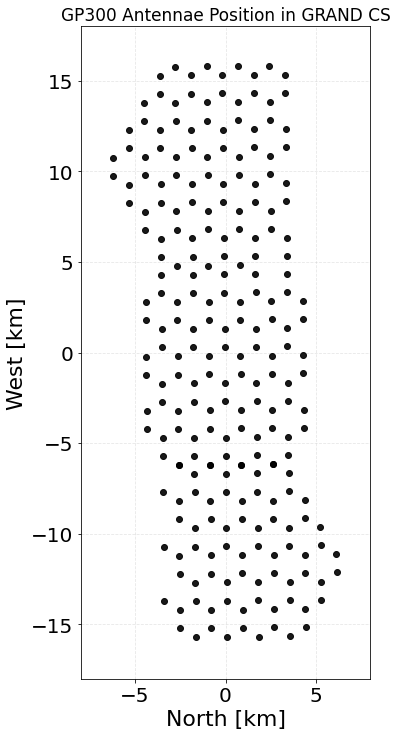

In [10]:
from grand import grand_get_path_root_pkg

layout = grand_get_path_root_pkg() + "/examples/geo/trial_GP300_layout_2021.txt"
geometry_file = np.loadtxt(layout)
longitude = geometry_file[:, 0]
latitude = geometry_file[:, 1]
altitude = geometry_file[:, 2]

grand_origin = Geodetic(
    latitude=np.mean(latitude), longitude=np.mean(longitude), height=np.mean(altitude)
)

# Conversion from Geodetic to GRAND coordinate system.
geod = Geodetic(latitude=latitude, longitude=longitude, height=altitude)
gcs = GRANDCS(geod, obstime="2021-08-25", location=grand_origin)

# ----Plot position of antannae in GRAND coordinate system----
x = (gcs.x) / 1000.0  # m -> km
y = (gcs.y) / 1000.0  # m -> km

plt.figure()
plt.plot(x, y, "ko", alpha=0.9)
plt.xlim(-8, 8)
plt.ylim(-18, 18)
plt.gca().set_aspect("equal")
plt.title("GP300 Antennae Position in GRAND CS")
plt.xlabel("North [km]")
plt.ylabel("West [km]")
plt.grid(ls="--", alpha=0.3)
# plt.savefig('GP300_layout_GRANDCS.png')